<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Check-your-sample-table-(i.e.-metadata-file)" data-toc-modified-id="Check-your-sample-table-(i.e.-metadata-file)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Check your sample table (i.e. metadata file)</a></span></li><li><span><a href="#Check-your-TRN" data-toc-modified-id="Check-your-TRN-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Check your TRN</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Load the data</a></span></li></ul></li><li><span><a href="#Regulatory-iModulons" data-toc-modified-id="Regulatory-iModulons-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Regulatory iModulons</a></span></li><li><span><a href="#Functional-iModulons" data-toc-modified-id="Functional-iModulons-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Functional iModulons</a></span><ul class="toc-item"><li><span><a href="#GO-Enrichments" data-toc-modified-id="GO-Enrichments-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>GO Enrichments</a></span></li><li><span><a href="#KEGG-Enrichments" data-toc-modified-id="KEGG-Enrichments-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>KEGG Enrichments</a></span><ul class="toc-item"><li><span><a href="#Load-KEGG-mapping" data-toc-modified-id="Load-KEGG-mapping-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Load KEGG mapping</a></span></li><li><span><a href="#Perform-enrichment" data-toc-modified-id="Perform-enrichment-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Perform enrichment</a></span></li><li><span><a href="#Convert-KEGG-IDs-to-human-readable-names" data-toc-modified-id="Convert-KEGG-IDs-to-human-readable-names-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Convert KEGG IDs to human-readable names</a></span></li><li><span><a href="#Save-files" data-toc-modified-id="Save-files-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Save files</a></span></li></ul></li></ul></li><li><span><a href="#Check-for-single-gene-iModulons" data-toc-modified-id="Check-for-single-gene-iModulons-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Check for single gene iModulons</a></span></li><li><span><a href="#Compare-against-published-iModulons" data-toc-modified-id="Compare-against-published-iModulons-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Compare against published iModulons</a></span></li><li><span><a href="#Save-iModulon-object" data-toc-modified-id="Save-iModulon-object-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Save iModulon object</a></span></li><li><span><a href="#Coming-soon" data-toc-modified-id="Coming-soon-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Coming soon</a></span></li></ul></div>

# Setup
This IPython notebook will walk through the steps of characterizing iModulons through semi-automated tools. You will need:
* M and A matrices
* Expression data (e.g. `log_tpm_norm.csv`)
* Gene table and KEGG/GO annotations (Generated in `gene_annotation.ipynb`)
* Sample table, with a column for `project` and `condition`
* TRN file

Optional:
* iModulon table (if you already have some characterized iModulons)

In [1]:
from pymodulon.core import IcaData
from os import path
import pandas as pd
import re
from Bio.KEGG import REST
from tqdm.notebook import tqdm

In [2]:
# Enter the location of your data here
data_dir = '../Pputida_data'

## Check your sample table (i.e. metadata file)
Your metadata file will probably have a lot of columns, most of which you may not care about. Feel free to save a secondary copy of your metadata file with only columns that seem relevant to you. The two most important columns are:
1. `project`
2. `condition`

Make sure that these columns exist in your metadata file

In [3]:
df_metadata = pd.read_csv(path.join(data_dir,'sample_table_only.csv'),index_col=0)
df_metadata[['project','condition']].head()

,project,condition
sample_id,,
CJ522_f_1,Muconate,Muc_CJ522_fructose
CJ522_f_2,Muconate,Muc_CJ522_fructose
CJ522_f_3,Muconate,Muc_CJ522_fructose
CJ522_fg_1,Muconate,Muc_CJ522_fructose_glucose
CJ522_fg_2,Muconate,Muc_CJ522_fructose_glucose


In [4]:
print(df_metadata.project.notnull().all())
print(df_metadata.condition.notnull().all())

True
True


## Check your TRN

Each row of the TRN file represents a regulatory interaction.  
**Your TRN file must have the following columns:**
1. `regulator` - Name of regulator (`/` or `+` characters will be converted to `;`)
1. `gene_id` - Locus tag of gene being regulated

The following columns are optional, but are helpful to have:
1. `regulator_id` - Locus tag of regulator
1. `gene_name` - Name of gene (can automatically update this using `name2num`)
1. `direction` - Direction of regulation ('+' for activation, '-' for repression, '?' or NaN for unknown)
1. `evidence` - Evidence of regulation (e.g. ChIP-exo, qRT-PCR, SELEX, Motif search)
1. `PMID` - Reference for regulation

You may add any other columns that could help you. TRNs may be saved as either CSV or TSV files. See below for an example:

In [5]:
df_trn = pd.read_csv(path.join(data_dir,'TRN_update.csv'))
df_trn.head()

,Unnamed: 0,regulator,regulator_id,gene_id,gene_name,evidence
0,0,PP_0119,PP_0119,PP_0117,znuB,NaN
1,1,PP_0119,PP_0119,PP_0118,znuC,NaN
2,2,PP_0119,PP_0119,PP_0119,PP_0119,NaN
3,3,PP_0119,PP_0119,PP_0120,PP_0120,NaN
4,4,PP_0119,PP_0119,PP_0508,PP_0508,NaN


The `regulator` and `gene_id` must be filled in for each row

In [6]:
print(df_trn.regulator.notnull().all())
print(df_trn.gene_id.notnull().all())

True
True


## Load the data
You're now ready to load your IcaData object!

In [7]:
ica_data = IcaData(M = path.join(data_dir,'M.csv'),
                   A = path.join(data_dir,'A.csv'),
                   X = path.join(data_dir,'log_tpm.csv'),
                   gene_table = path.join(data_dir,'gene_info.csv'),
                   sample_table = path.join(data_dir,'sample_table_only.csv'),
                   trn = path.join(data_dir,'TRN_update.csv'))

/Users/hyungyu/Dropbox (Personal)/Jupyter_py_notebook/pymodulon-github/pymodulon/pymodulon/core.py:259: UserWarning: The following genes are in the TRN but not in your M matrix: {'PP_1796', 'PP_2629', 'PP_3101', 'PP_3462', 'PP_4292'}
  warnings.warn('The following genes are in the TRN but not in '


If you don't have a TRN (or have a very minimal TRN), use `threshold_method = 'kmeans'`

In [8]:
#
#ica_data = IcaData(M = path.join(data_dir,'M.csv'),
#                  A = path.join(data_dir,'A.csv'),
#                   X = path.join(data_dir,'X.csv'),
#                   gene_table = path.join(data_dir,'gene_table.csv'),
#                   sample_table = path.join(data_dir,'sample_table.csv'),
#                   trn = path.join(data_dir,'TRN.tsv'),
#                   threshold_method = 'kmeans')

In [9]:
ica_data.recompute_thresholds


<bound method IcaData.recompute_thresholds of <pymodulon.core.IcaData object at 0x7fc4a705bc70>>

1150

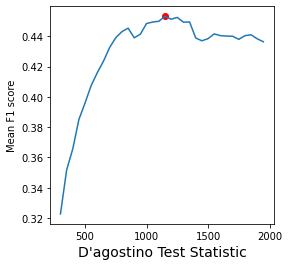

In [10]:
ica_data.reoptimize_thresholds()

In [11]:
ica_data.imodulon_table.to_csv('../Pputida_data/Reopt_imodulon/iModulon_table_reopt.csv')

In [12]:
from pymodulon.util import explained_variance

In [13]:
ica_data

In [14]:
explained_variance(ica_data)
#recovered_variance(ica_data)

65.64266162797374

In [20]:
ica_data.view_imodulon(45)

,gene_weight,gene_name,start,end,strand,product,uniprot,cog,KEGG_ko,operon,regulator
PP_0440,0.066006,tufA,532736,533929,+,Elongation factor Tu-A,NaN,J,K02358,tufA,FleQ
PP_0443,0.086687,rplK,535135,535566,+,50S ribosomal protein L11,NaN,J,K02867,rplA//rplK,NaN
PP_0444,0.089285,rplA,535566,536261,+,50S ribosomal protein L1,NaN,J,K02863,rplA//rplK,NaN
PP_0445,0.100747,rplJ,536459,536959,+,50S ribosomal protein L10,NaN,J,K02864,rplJ,NaN
PP_0446,0.093826,rplL,537037,537402,+,50S ribosomal protein L7/L12,NaN,J,NaN,rplL,NaN
...,...,...,...,...,...,...,...,...,...,...,...
PP_5413,0.060982,atpD,6175220,6176596,-,ATP synthase subunit beta,NaN,F,K02112,atpI//atpB//atpE//atpF//atpH//atpA//atpG//atpD...,NaN
PP_5414,0.063296,atpG,6176624,6177484,-,ATP synthase gamma chain,NaN,C,K02115,atpI//atpB//atpE//atpF//atpH//atpA//atpG//atpD...,NaN
PP_5415,0.069464,atpA,6177533,6179077,-,ATP synthase subunit alpha,NaN,F,K02111,atpI//atpB//atpE//atpF//atpH//atpA//atpG//atpD...,NaN
PP_5416,0.059745,atpH,6179099,6179635,-,ATP synthase subunit delta,NaN,C,K02113,atpI//atpB//atpE//atpF//atpH//atpA//atpG//atpD...,NaN


In [20]:
ica_data.imodulons_with('gapA')

AttributeError: 'IcaData' object has no attribute 'imodulons_with'

In [11]:
ica_data.name2num('PP_2589')

AttributeError: 'IcaData' object has no attribute 'name2num'

In [ ]:
#ica_data.imodulon_table.to_csv('../Pputida_data/iModulon_table_pputida.csv')

In [24]:
mylist = []
for k in ica_data.imodulon_names:
        mylist.append(",".join([str(k)]+ica_data.view_imodulon(k).index.to_list()))

In [25]:
with open("../Pputida_data/Reopt_imodulon/imodulons.csv","w") as f:
    f.write("\n".join(mylist))

In [26]:
mylist2 = []
for k in ica_data.imodulon_names:
    mylist2.append(",".join([str(k)]+ica_data.view_imodulon(k).gene_name.to_list()))
    
with open("imodulons_files_reoptimize.csv","w") as f:
    f.write("\n".join(mylist2))  

In [27]:
#to see the content of iModulons

ica_data.view_imodulon(6)



,gene_weight,gene_name,start,end,strand,product,uniprot,cog,KEGG_ko,operon,regulator
locus_tag,,,,,,,,,,,
PP_1014,0.237288,yihS,1156513,1157763,+,aldose-ketose isomerase,NaN,G,NaN,yihS,NaN
PP_1015,0.394889,gtsA,1157868,1159154,+,mannose/glucose ABC transporter%2C glucose-bin...,NaN,G,K17315,gtsA,"PP_1012,PP_5292"
PP_1016,0.359135,gtsB,1159288,1160196,+,mannose/glucose ABC transporter%2C permease pr...,NaN,P,K17316,oprB-I//gtsD//gtsC//gtsB,PP_1012
PP_1017,0.372059,gtsC,1160189,1161034,+,mannose/glucose ABC transporter%2C permease pr...,NaN,P,K17317,oprB-I//gtsD//gtsC//gtsB,PP_1012
PP_1018,0.374684,gtsD,1161038,1162192,+,mannose/glucose ABC transporter - ATP binding ...,NaN,P,K10112,oprB-I//gtsD//gtsC//gtsB,PP_1012
PP_1019,0.335302,oprB-I,1162233,1163576,+,carbohydrate-selective porin,NaN,M,K07267,oprB-I//gtsD//gtsC//gtsB,"PP_1012,PP_1013,PP_5292"
PP_1020,0.128111,yeaD,1163694,1164548,+,putative glucose-6-phosphate 1-epimerase,NaN,G,NaN,yeaD,NaN


# Regulatory iModulons
Use `compute_trn_enrichment` to automatically check for Regulatory iModulons. The more complete your TRN, the more regulatory iModulons you'll find.

In [17]:
ica_data.compute_trn_enrichment()

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,3,FnrA,5.942576e-08,9.151566e-06,0.363636,0.181818,0.242424,4.0,11.0,22.0,1.0
1,4,PP_3738,3.485171e-10,5.367163e-08,1.000000,0.600000,0.750000,3.0,3.0,5.0,1.0
2,6,PP_1012,2.648762e-14,4.079094e-12,0.625000,0.714286,0.666667,5.0,8.0,7.0,1.0
3,8,Cra,5.575521e-10,8.586303e-08,0.750000,0.750000,0.750000,3.0,4.0,4.0,1.0
4,11,PP_0119,9.114664e-36,1.403658e-33,1.000000,0.454545,0.625000,15.0,15.0,33.0,1.0
5,12,PtxS,3.171745e-09,4.884487e-07,0.500000,0.250000,0.333333,4.0,8.0,16.0,1.0
6,15,GbdR,2.756178e-21,4.244515e-19,1.000000,0.272727,0.428571,9.0,9.0,33.0,1.0
7,19,FleQ,6.595513e-37,1.015709e-34,0.109091,0.909091,0.194805,30.0,275.0,33.0,1.0
8,20,BenR,4.182205e-09,6.440596e-07,1.000000,0.300000,0.461538,3.0,3.0,10.0,1.0
9,24,PcaR,4.877861e-09,7.511905e-07,1.000000,0.083333,0.153846,4.0,4.0,48.0,1.0


You can also search for AND/OR combinations of regulators using the `max_regs` argument. Here, we see that iModulon #4 may be regulated by the both ArnR;ArnR1 and ArnA;ArnB.

In [18]:
ica_data.compute_trn_enrichment(max_regs=2)

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,4,PP_3738,3.485171e-10,2.093194e-06,1.000000,0.600000,0.750000,3.0,3.0,5.0,1.0
1,6,PP_1012,2.648762e-14,1.590847e-10,0.625000,0.714286,0.666667,5.0,8.0,7.0,1.0
2,8,Cra,5.575521e-10,3.348658e-06,0.750000,0.750000,0.750000,3.0,4.0,4.0,1.0
3,11,PP_0119,9.114664e-36,5.474267e-32,1.000000,0.454545,0.625000,15.0,15.0,33.0,1.0
4,15,GbdR,2.756178e-21,1.655361e-17,1.000000,0.272727,0.428571,9.0,9.0,33.0,1.0
5,19,FleQ,6.595513e-37,3.961265e-33,0.109091,0.909091,0.194805,30.0,275.0,33.0,1.0
6,31,FliA,2.946226e-11,1.769503e-07,0.500000,0.176471,0.260870,6.0,12.0,34.0,1.0
7,33,GlcC,1.253433e-13,7.528120e-10,0.800000,1.000000,0.888889,4.0,5.0,4.0,1.0
8,40,GlnG,9.140627e-17,5.489861e-13,0.142857,0.818182,0.243243,9.0,63.0,11.0,1.0
9,43,FleQ+AmrZ,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000,12.0,12.0,12.0,2.0


Regulator enrichments can be directly saved to the `imodulon_table` using the `save` argument. This saves the enrichment with the lowest q-value to the table. For iModulon #4, it will automatically save `ArnR;ArnR1` as the enrichment, but we want to save `ArnR;ArnR1+ArnA;ArnB`. We can update our enrichments accordingly, using `compute_regulon_enrichment`:

In [19]:
ica_data.compute_trn_enrichment(max_regs=2,save=True)

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,4,PP_3738,3.485171e-10,2.093194e-06,1.000000,0.600000,0.750000,3.0,3.0,5.0,1.0
1,6,PP_1012,2.648762e-14,1.590847e-10,0.625000,0.714286,0.666667,5.0,8.0,7.0,1.0
2,8,Cra,5.575521e-10,3.348658e-06,0.750000,0.750000,0.750000,3.0,4.0,4.0,1.0
3,11,PP_0119,9.114664e-36,5.474267e-32,1.000000,0.454545,0.625000,15.0,15.0,33.0,1.0
4,15,GbdR,2.756178e-21,1.655361e-17,1.000000,0.272727,0.428571,9.0,9.0,33.0,1.0
5,19,FleQ,6.595513e-37,3.961265e-33,0.109091,0.909091,0.194805,30.0,275.0,33.0,1.0
6,31,FliA,2.946226e-11,1.769503e-07,0.500000,0.176471,0.260870,6.0,12.0,34.0,1.0
7,33,GlcC,1.253433e-13,7.528120e-10,0.800000,1.000000,0.888889,4.0,5.0,4.0,1.0
8,40,GlnG,9.140627e-17,5.489861e-13,0.142857,0.818182,0.243243,9.0,63.0,11.0,1.0
9,43,FleQ+AmrZ,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000,12.0,12.0,12.0,2.0


In [31]:
ica_data.sample_table.to_csv('../Pputida_data/Reopt_imodulon/sample_table.csv')

In [20]:
ica_data.imodulon_table.head()

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PP_3738,3.485171e-10,0.000002,1.0,0.6,0.75,3.0,3.0,5.0,1.0


In [21]:
ica_data.imodulon_table

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PP_3738,3.485171e-10,2.093194e-06,1.000000,0.600000,0.750000,3.0,3.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...
86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,PedR1,1.600532e-11,9.612792e-08,0.172414,0.833333,0.285714,5.0,29.0,6.0,1.0
88,GlnG,1.073307e-30,6.446285e-27,0.238095,1.000000,0.384615,15.0,63.0,15.0,1.0
89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
ica_data.compute_regulon_enrichment(43,'FleQ+AmrZ;AmrZ;FleQ',save=True)

pvalue            1
precision         0
recall            0
f1score           0
TP                0
regulon_size      0
imodulon_size    12
n_regs            2
Name: FleQ+AmrZ;AmrZ;FleQ, dtype: int64

In [ ]:
ica_data.compute_regulon_enrichment(55,'HexR;HexR+GlnG',save=True)

In [ ]:
ica_data.compute_regulon_enrichment(57,'RbsR;FinR',save=True)

In [ ]:
ica_data.imodulon_table.head()

In [35]:
ica_data.imodulon_table.to_csv('../Pputida_data/Reopt_imodulon/iModulon_table.csv')

You can rename iModulons in this jupyter notebook, or you can save the iModulon table as a CSV and edit it in Excel.

In [23]:
reg_entries = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]
reg_entries

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
4,PP_3738,3.485171e-10,2.093194e-06,1.000000,0.600000,0.750000,3.0,3.0,5.0,1.0
6,PP_1012,2.648762e-14,1.590847e-10,0.625000,0.714286,0.666667,5.0,8.0,7.0,1.0
8,Cra,5.575521e-10,3.348658e-06,0.750000,0.750000,0.750000,3.0,4.0,4.0,1.0
11,PP_0119,9.114664e-36,5.474267e-32,1.000000,0.454545,0.625000,15.0,15.0,33.0,1.0
15,GbdR,2.756178e-21,1.655361e-17,1.000000,0.272727,0.428571,9.0,9.0,33.0,1.0
19,FleQ,6.595513e-37,3.961265e-33,0.109091,0.909091,0.194805,30.0,275.0,33.0,1.0
31,FliA,2.946226e-11,1.769503e-07,0.500000,0.176471,0.260870,6.0,12.0,34.0,1.0
33,GlcC,1.253433e-13,7.528120e-10,0.800000,1.000000,0.888889,4.0,5.0,4.0,1.0
40,GlnG,9.140627e-17,5.489861e-13,0.142857,0.818182,0.243243,9.0,63.0,11.0,1.0
43,FleQ+AmrZ;AmrZ;FleQ,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.0,12.0,2.0


In [16]:
ica_data.rename_imodulons(reg_entries.regulator.to_dict())
print(ica_data.imodulon_names[:5])

NameError: name 'reg_entries' is not defined

In [39]:
ica_data.imodulon_table.to_csv('../Pputida_data/Reopt_imodulon/iModulon_table.csv')

You can also manually rename iModulons with long names

In [ ]:
ica_data.rename_imodulons({'ArnR;ArnR1+ArnA;ArnB':'ArnRAB'})

In [ ]:
ica_data.imodulon_names[:5]

# Functional iModulons

## GO Enrichments

The `GO_annotations.csv` file was created from `gene_annotation.ipynb`.

In [40]:
DF_GO = pd.read_csv(path.join(data_dir,'GO_annotations_pp.csv'),index_col=0)
DF_GO.head()

,gene_id,gene_ontology
0,PP_4621,transcription regulatory region sequence-speci...
1,PP_4621,DNA-binding transcription repressor activity
2,PP_4621,"homogentisate 1,2-dioxygenase activity"
3,PP_4621,iron ion binding
4,PP_4621,L-phenylalanine catabolic process


In [41]:
DF_GO_enrich = ica_data.compute_annotation_enrichment(DF_GO,'gene_ontology')

In [42]:
DF_GO_enrich.to_csv(path.join(data_dir,'GO_enrichments.csv'))

## KEGG Enrichments

### Load KEGG mapping
The `kegg_mapping.csv` file was created from `gene_annotation.ipynb`. This contains KEGG orthologies, pathways, modules, and reactions. Only pathways and modules are relevant to iModulon characterization.

In [43]:
DF_KEGG = pd.read_csv(path.join(data_dir,'kegg_mapping.csv'),index_col=0)
print(DF_KEGG.database.unique())
DF_KEGG.head()

['KEGG_pathway' 'KEGG_module' 'KEGG_reaction']


,gene_id,database,kegg_id
2485,PP_0006,KEGG_pathway,map02024
2486,PP_0006,KEGG_pathway,map03060
2487,PP_0006,KEGG_pathway,map03070
2490,PP_0010,KEGG_pathway,map02020
2491,PP_0010,KEGG_pathway,map04112


In [44]:
kegg_pathways = DF_KEGG[DF_KEGG.database == 'KEGG_pathway']
kegg_modules = DF_KEGG[DF_KEGG.database == 'KEGG_module']

### Perform enrichment
Uses the `compute_annotation_enrichment` function

In [45]:
DF_pathway_enrich = ica_data.compute_annotation_enrichment(kegg_pathways,'kegg_id')
DF_module_enrich = ica_data.compute_annotation_enrichment(kegg_modules,'kegg_id')

In [46]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,0,map00920,2.315989e-22,5.118337e-20,0.382353,0.419355,0.400000,13.0,34.0,31.0
1,0,map02010,6.456197e-10,7.134098e-08,0.065868,0.354839,0.111111,11.0,167.0,31.0
2,3,map00190,2.925401e-05,6.465136e-03,0.085106,0.181818,0.115942,4.0,47.0,22.0
3,PP_3738,map00627,2.320292e-05,5.127846e-03,0.222222,0.400000,0.285714,2.0,9.0,5.0
4,PP_3738,map00830,8.986341e-04,6.619938e-02,1.000000,0.200000,0.333333,1.0,1.0,5.0


In [47]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,0,M00436,3.928606e-09,1.123581e-06,0.800000,0.129032,0.222222,4.0,5.0,31.0
1,0,M00435,1.566584e-07,2.240216e-05,1.000000,0.096774,0.176471,3.0,3.0,31.0
2,0,M00185,1.554776e-06,1.482219e-04,0.600000,0.096774,0.166667,3.0,5.0,31.0
3,1,M00236,9.203204e-07,2.632116e-04,0.142857,0.500000,0.222222,3.0,21.0,6.0
4,3,M00156,9.145117e-10,2.615503e-07,0.800000,0.181818,0.296296,4.0,5.0,22.0


### Convert KEGG IDs to human-readable names

In [48]:
for idx,key in tqdm(DF_pathway_enrich.kegg_id.items(),total=len(DF_pathway_enrich)):
    text = REST.kegg_find('pathway',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_pathway_enrich.loc[idx,'pathway_name'] = name
    except AttributeError:
        DF_pathway_enrich.loc[idx,'pathway_name'] = None
    
for idx,key in tqdm(DF_module_enrich.kegg_id.items(),total=len(DF_module_enrich)):
    text = REST.kegg_find('module',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_module_enrich.loc[idx,'module_name'] = name
    except AttributeError:
        DF_module_enrich.loc[idx,'module_name'] = None

In [49]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
0,0,map00920,2.315989e-22,5.118337e-20,0.382353,0.419355,0.400000,13.0,34.0,31.0,Sulfur metabolism
1,0,map02010,6.456197e-10,7.134098e-08,0.065868,0.354839,0.111111,11.0,167.0,31.0,ABC transporters
2,3,map00190,2.925401e-05,6.465136e-03,0.085106,0.181818,0.115942,4.0,47.0,22.0,Oxidative phosphorylation
3,PP_3738,map00627,2.320292e-05,5.127846e-03,0.222222,0.400000,0.285714,2.0,9.0,5.0,Aminobenzoate degradation
4,PP_3738,map00830,8.986341e-04,6.619938e-02,1.000000,0.200000,0.333333,1.0,1.0,5.0,Retinol metabolism


In [50]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
0,0,M00436,3.928606e-09,1.123581e-06,0.800000,0.129032,0.222222,4.0,5.0,31.0,NaN
1,0,M00435,1.566584e-07,2.240216e-05,1.000000,0.096774,0.176471,3.0,3.0,31.0,NaN
2,0,M00185,1.554776e-06,1.482219e-04,0.600000,0.096774,0.166667,3.0,5.0,31.0,NaN
3,1,M00236,9.203204e-07,2.632116e-04,0.142857,0.500000,0.222222,3.0,21.0,6.0,NaN
4,3,M00156,9.145117e-10,2.615503e-07,0.800000,0.181818,0.296296,4.0,5.0,22.0,"Cytochrome c oxidase, cbb3-type"


### Save files

In [51]:
DF_pathway_enrich.to_csv(path.join(data_dir,'Reopt_imodulon/kegg_pathway_enrichments.csv'))
DF_pathway_enrich.to_csv(path.join(data_dir,'Reopt_imodulon/kegg_module_enrichments.csv'))

# Check for single gene iModulons

In [52]:
sg_imods = ica_data.find_single_gene_imodulons(save=True)

In [53]:
sg_imods

[5, 7, 52, 66, 82]

In [54]:
for i,mod in enumerate(sg_imods):
    ica_data.rename_imodulons({mod:'single_gene_'+str(i+1)})

In [55]:
ica_data.imodulon_names[:10]

[0, 1, 2, 3, 'PP_3738', 'single_gene_1', 'PP_1012', 'single_gene_2', 'Cra', 9]

In [56]:
ica_data.imodulon_table.to_csv('../Pputida_data/Reopt_imodulon/iModulon_table_save.csv')

# Compare against published iModulons
We can use the `compare_ica` function to compare iModulons across different organisms. To do so, you must provide the path to a Bidirection Best Hist CSV between your two organisms of interest.

A Github repository containing many BBH CSV's can be found at the following
link: https://urldefense.com/v3/__https://github.com/SBRG/modulome_compare_data/tree/master/bbh_csv*5Cn__;JQ!!Mih3wA!QpB644kIC6gJZV42W8smF18ewZ7nCuSDtUNh1MZQBhG4iG6RHFDeJw-TgW0SD_HoIbo$ 
You can also provide a path to your own BBH file, as long as it contains the
columns "**gene**" and "**target**"

See the `Tutorial.ipynb` notebook for more information

In [58]:
from pymodulon.compare import *
from pymodulon.io import *

In [ ]:
ecoli_data = load_json_model('../example_data/example.json')

In [ ]:
dots,links = compare_ica(ecoli_data.M, ica_data.M, cutoff=0.3,
                         ortho_file = '../Pputida_data/bbh/eColi_full_protein_vs_pPutida_full_protein_parsed.csv')
dots

In the above plot, the top named iModulons are from *E. coli* and the bottom iModulons are from our target organism. Note that the two FadR iModulons are linked together. This `links` variable contains all pairs of iModulons that are linked together

In [ ]:
links

In [ ]:
for ecoli_mod,target_mod in links:
    ica_data.imodulon_table.loc[target_mod,'ecoli_ortholog'] = ecoli_mod
ica_data.imodulon_table.head()

# Save iModulon object

This will save your iModulon table, your thresholds, and any other information stored in the ica_data object.

In [59]:
save_to_json(ica_data,'../Pputida_data/Reopt_imodulon/Pputida.json')

If you prefer to view and edit your iModulon table in excel, save it as a CSV and reload the iModulon as before

In [60]:
ica_data.imodulon_table.to_csv('../Pputida_data/Reopt_imodulon/iModulon_table.csv')

# Coming soon

1. Saving GO/KEGG enrichments to iModulon table
1. Plotting iModulon gene weights across organisms
1. Using iModulon activities to characterize iModulons
1. Finding motifs using MEME
1. Building iModulonDB web pages


In [ ]:
#to see the content of iModulons

ica_data.view_imodulon(51)

In [ ]:
ica_data.view_imodulon(26)

In [ ]:
ica_data.view_imodulon(4)

In [ ]:
ica_data.view_imodulon(20)

In [ ]:
ica_data.view_imodulon(39)

In [ ]:
ica_data.view_imodulon(24)

In [ ]:
ica_data.view_imodulon(4)

In [ ]:
ica_data.view_imodulon(8)

In [ ]:
ica_data.view_imodulon(2).to_csv('../Pputida_data/imodulon_files/2_gene_file.csv')

In [ ]:
ica_data.view_imodulon(2)

In [ ]:
ica_data.view_imodulon(29)

In [8]:
ica_data.view_imodulon(51)

,gene_weight,gene_name,start,end,strand,product,uniprot,cog,KEGG_ko,operon,regulator
locus_tag,,,,,,,,,,,
PP_0137,0.095667,gltP,144767,146095,+,glutamate/aspartate-proton DAACS transporter,NaN,C,K11102,gltP,NaN
PP_1188,0.277589,dctA-I,1363308,1364630,+,C4-dicarboxylate transport protein,NaN,C,K11103,dctA-I,NaN
PP_2453,0.104999,ansB,2799202,2800290,-,Glutaminase-asparaginase,NaN,E,K05597,ansB,NaN
PP_4734,0.077869,pdhR,5382513,5383280,-,DNA-binding transcriptional dual regulator%2C ...,NaN,K,K05799,pdhR,PdhR
PP_4735,0.424836,lldP,5383537,5385207,+,L-lactate permease,NaN,C,K03303,dld2//lldD//lldP,"PdhR,PP_5292"
PP_4736,0.328407,lldD,5385270,5386415,+,L-lactate dehydrogenase,NaN,C,K00101,dld2//lldD//lldP,PdhR
PP_4737,0.286253,dld2,5386491,5389301,+,D-lactate dehydrogenase,NaN,C,K18930,dld2//lldD//lldP,PdhR


In [62]:
ica_data.view_imodulon(16)

,gene_weight,gene_name,start,end,strand,product,uniprot,cog,KEGG_ko,operon,regulator
locus_tag,,,,,,,,,,,
PP_0051,0.071417,PP_0051,59316,60608,-,putative sigma-54 dependent transcriptional re...,NaN,K,NaN,PP_0051,FleQ
PP_0154,0.124859,scpC,162340,163833,-,propionyl-CoA:succinate CoA transferase,NaN,C,K18118,scpC,PedR1
PP_0234,0.064211,oprE,288582,289916,+,outer-membrane porin E,NaN,M,NaN,oprE,NaN
PP_0353,0.143474,PP_0353,429669,430379,-,Exonuclease,NaN,L,K02342,PP_0354//PP_0353,NaN
PP_0354,0.119447,PP_0354,430376,432313,-,CBS domain protein,NaN,T,K07182,PP_0354//PP_0353,NaN
PP_0530,0.087210,ribB,615651,616301,-,3%2C4-dihydroxy-2-butanone 4-phosphate synthase,NaN,H,K02858,ribB,NaN
PP_0751,0.103672,mqo-I,868079,869587,-,malate:quinone oxidoreductase,NaN,C,K00116,mqo-I,NaN
PP_0791,0.065798,yjjV,907434,908210,-,putative hydrolase,NaN,L,K03424,cra//yjjV,NaN
PP_0792,0.077682,cra,908213,909208,-,catabolite repressor-activator%2C DNA-binding ...,NaN,K,K03435,cra//yjjV,Cra


In [70]:
ica_data.view_imodulon('PsrA')

,gene_weight,gene_name,start,end,strand,product,uniprot,cog,KEGG_ko,operon,regulator
locus_tag,,,,,,,,,,,
PP_0338,-0.085427,aceF,406364,408004,-,AceF-S-acetyldihydrolipoate,NaN,C,K00627,aceE//aceF,PP_5350
PP_0339,-0.079394,aceE,408018,410663,-,Pyruvate dehydrogenase E1 component,NaN,C,K00163,aceE//aceF,PP_5350
PP_0368,0.099634,PP_0368,445315,447120,+,putative Acyl-CoA dehydrogenase,NaN,C,NaN,PP_0368,PsrA
PP_0370,0.120462,PP_0370,448830,450608,+,Acyl-CoA dehydrogenase family protein,NaN,C,NaN,PP_0370//PP_0369,NaN
PP_1075,0.085744,glpK,1233786,1235285,-,glycerol kinase,NaN,F,K00864,glpF//glpK//glpR//glpD,"GlpR,GlnG"
PP_1076,0.103361,glpF,1235337,1236188,-,aquaglyceroporin,NaN,G,K02440,glpF//glpK//glpR//glpD,"GlpR,GlnG,PP_5292"
PP_1185,0.113640,oprH,1360135,1360740,+,Outer membrane protein H1,NaN,M,NaN,oprH,FleQ
PP_1186,0.077830,phoP,1360937,1361614,+,two component system DNA-binding transcription...,NaN,K,K07660,phoQ//phoP,FleQ
PP_1689,0.104174,PP_1689,1881298,1882563,-,putative Long-chain fatty acid transporter,NaN,I,K06076,PP_1689,NaN


In [71]:
ica_data.view_imodulon('PP_3603')

,gene_weight,gene_name,start,end,strand,product,uniprot,cog,KEGG_ko,operon,regulator
locus_tag,,,,,,,,,,,
PP_1168,0.110018,PP_1168,1343552,1344136,-,putative TRAP dicarboxylate transporter%2C Dct...,NaN,G,NaN,dctP//PP_1168//PP_1167,PP_3603
PP_1169,0.131996,dctP,1344146,1345117,-,TRAP dicarboxylate transporter%2C DctP subunit,NaN,G,NaN,dctP//PP_1168//PP_1167,PP_3603
PP_1170,0.163023,gnl,1345182,1346063,-,Gluconolactonase,NaN,G,NaN,udh//gnl,PP_3603
PP_1171,0.150792,udh,1346086,1346892,-,uronate dehydrogenase,NaN,M,K18981,udh//gnl,PP_3603
PP_1173,0.143105,galP-I,1347296,1348534,-,porin-like protein,NaN,S,NaN,galP-I,NaN
PP_2628,0.110616,PP_2628,3007118,3009094,-,Uncharacterized ABC transporter ATP-binding pr...,NaN,P,K18893,PP_2628,FleQ
PP_3455,0.110426,PP_3455,3915032,3916207,+,Multidrug efflux RND membrane fusion protein,NaN,M,NaN,mexB//PP_3455,NaN
PP_3456,0.125108,mexB,3916219,3919347,+,Multidrug resistance protein MexB,NaN,P,K18138,mexB//PP_3455,NaN
PP_3599,0.183183,kdgD,4088934,4089845,+,5-dehydro-4-deoxyglucarate dehydratase,NaN,E,K01707,kdgD,PP_3603


In [73]:
ica_data.view_imodulon('PdhR')

,gene_weight,gene_name,start,end,strand,product,uniprot,cog,KEGG_ko,operon,regulator
locus_tag,,,,,,,,,,,
PP_1188,0.277589,dctA-I,1363308,1364630,+,C4-dicarboxylate transport protein,NaN,C,K11103,dctA-I,NaN
PP_2453,0.104999,ansB,2799202,2800290,-,Glutaminase-asparaginase,NaN,E,K05597,ansB,NaN
PP_4735,0.424836,lldP,5383537,5385207,+,L-lactate permease,NaN,C,K03303,dld2//lldD//lldP,"PdhR,PP_5292"
PP_4736,0.328407,lldD,5385270,5386415,+,L-lactate dehydrogenase,NaN,C,K00101,dld2//lldD//lldP,PdhR
PP_4737,0.286253,dld2,5386491,5389301,+,D-lactate dehydrogenase,NaN,C,K18930,dld2//lldD//lldP,PdhR


In [78]:
ica_data.view_imodulon(27)

,gene_weight,gene_name,start,end,strand,product,uniprot,cog,KEGG_ko,operon,regulator
locus_tag,,,,,,,,,,,
PP_1359,0.108980,PP_1359,1548554,1549015,+,conserved membrane protein of unknown function,NaN,S,K07113,PP_1359,NaN
PP_1360,0.156875,groS,1549260,1549553,+,10 kDa chaperonin,NaN,O,NaN,groS//PP_mr20,NaN
PP_1361,0.140433,groL,1549601,1551241,+,60 kDa chaperonin,NaN,O,K04077,groL,NaN
PP_1443,0.133571,lon-I,1642324,1644741,-,DNA-binding%2C ATP-dependent protease,NaN,O,"K01338,ko:K08675",lon-I,NaN
PP_1982,0.141211,ibpA,2245762,2246211,+,small heat shock protein IbpA,NaN,O,K04080,ibpA,NaN
PP_4179,0.155790,htpG,4721659,4723563,-,Chaperone protein HtpG,NaN,O,K04079,htpG,NaN
PP_4727,0.145021,dnaK,5375639,5377564,-,Chaperone protein DnaK,NaN,O,K04043,dnaK,NaN
PP_4728,0.161064,grpE,5377666,5378223,-,Protein GrpE,NaN,O,K03687,grpE,NaN
PP_5000,0.166002,hslV,5696760,5697290,+,peptidase component of the ATP-dependent HslVU...,NaN,O,K01419,hslV,NaN


In [83]:
ica_data.view_imodulon(80)

,gene_weight,gene_name,start,end,strand,product,uniprot,cog,KEGG_ko,operon,regulator
locus_tag,,,,,,,,,,,
PP_5430,0.059524,PP_5430,193882,194085,-,protein of unknown function,NaN,X,NaN,PP_5430,NaN
PP_0181,0.069872,PP_0181,233875,234120,-,conserved protein of unknown function,NaN,S,NaN,PP_0181,NaN
PP_0273,0.087699,PP_0273,332474,332686,-,conserved protein of unknown function,NaN,S,NaN,PP_0273,NaN
PP_0318,0.075619,PP_0318,382811,383041,+,conserved protein of unknown function,NaN,X,NaN,PP_0319//PP_0318,NaN
PP_0319,0.076827,PP_0319,383038,383340,+,conserved protein of unknown function,NaN,D,NaN,PP_0319//PP_0318,NaN
...,...,...,...,...,...,...,...,...,...,...,...
PP_5162,0.055900,PP_5162,5887145,5887714,+,conserved exported protein of unknown function,NaN,C,NaN,PP_5162,NaN
PP_5189,0.073688,PP_5189,5919002,5919307,+,conserved protein of unknown function,NaN,X,NaN,PP_5189,NaN
PP_5206,0.078919,yhiI,5936484,5937443,+,putative translation-related protein,NaN,M,K01993,yhhJ//rbbA//yhiI,FleQ


In [25]:
ica_data.view_imodulon(74)

,gene_weight,gene_name,start,end,strand,product,uniprot,cog,KEGG_ko,operon,regulator
PP_3635,0.138906,PP_3635,4131200,4131955,-,putative Sulfonate ABC transporter%2C permease...,NaN,P,K02050,PP_3638//PP_3637//PP_3636//PP_3635,NaN
PP_3636,0.165431,PP_3636,4131955,4133160,-,putative Sulfonate ABC transporter%2C periplas...,NaN,P,K02051,PP_3638//PP_3637//PP_3636//PP_3635,NaN
PP_3637,0.178107,PP_3637,4133147,4133968,-,putative Sulfonate ABC transporter%2C ATP-bind...,NaN,P,K02049,PP_3638//PP_3637//PP_3636//PP_3635,NaN
PP_3638,0.185951,PP_3638,4133965,4135029,-,putative Acyl-CoA dehydrogenase,NaN,I,NaN,PP_3638//PP_3637//PP_3636//PP_3635,NaN
PP_3639,0.361903,PP_3639,4135129,4135788,-,Alkylhydroperoxidase AhpD domain protein,NaN,O,NaN,PP_3639,NaN


In [24]:
ica_data.A

,CJ522_f_1,CJ522_f_2,CJ522_f_3,CJ522_fg_1,CJ522_fg_2,CJ522_fg_3,CJ522_gfg_1,CJ522_gfg_2,CJ522_gfg_3,CJ522_gg_1,...,SRX8245724,SRX8245725,SRX8245726,SRX8245727,SRX8245728,SRX8245729,SRX8245730,SRX8245731,SRX8245732,SRX8245733
0,-12.497933,-11.671854,-11.372362,-11.720531,-8.778028,-7.976384,-2.871031,-0.197420,1.936696,-6.199981,...,-10.517828,-9.357767,-7.643849,-8.515282,-7.027919,-6.408117,-3.474458,-3.628346,1.929963,-0.128937
1,-14.122896,-16.682085,-14.080176,-11.905723,-13.339560,-11.725473,-13.044692,-14.551088,-14.072812,-6.812925,...,-9.312394,-11.115023,-9.804043,-10.551385,-9.746263,-9.961759,-9.206954,-9.703880,-11.004166,-11.296676
2,20.043903,18.908668,19.123191,26.132196,24.674857,23.487323,24.579703,22.943053,23.489354,25.158273,...,14.464235,19.210003,23.914700,24.037751,33.464742,32.537770,27.406882,30.223691,27.471173,26.650103
3,4.154433,0.902301,0.181144,0.663866,0.890491,2.898735,1.957676,-0.309626,2.629417,11.552997,...,25.219428,26.911147,25.453396,26.004669,26.480716,26.096561,26.400353,25.798351,24.637643,24.264979
4,-5.296382,-4.575032,-3.709409,-5.390005,-5.125200,-5.329107,-5.682437,-5.040126,-5.326131,-5.528460,...,-1.063726,-0.686420,-1.359299,-1.215237,-2.312056,-1.950936,-2.020063,-1.248257,-2.329865,-2.477266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,26.987967,21.891644,22.695401,31.951231,32.335003,32.315004,33.329569,30.155344,26.632014,24.702037,...,31.437722,34.827447,27.075359,27.401297,27.799067,27.577245,30.406182,28.528919,27.530422,26.775085
87,12.281972,9.843405,10.714087,14.359958,9.303336,11.298069,9.054005,8.598754,7.770792,10.766524,...,2.926779,1.465204,3.168917,2.300130,2.124523,3.284812,2.508776,3.328314,1.999146,3.506770
88,-14.532671,-14.735319,-14.704197,-14.707542,-15.976423,-17.526961,-18.389024,-15.565333,-14.479110,-21.690724,...,-16.032354,-16.622069,-18.457447,-17.595004,-18.998532,-19.393200,-20.724312,-20.874739,-20.717066,-20.951257
89,-2.984196,-3.567567,0.581562,3.818145,3.378912,2.453013,3.230834,3.962824,4.840624,0.567121,...,-1.120709,-2.367367,-3.310164,-4.076027,1.733060,1.237385,-1.089968,-0.398107,-1.405343,-1.061400


In [87]:
ica_data.A.to_csv('new_A.csv')

In [30]:
#ica_data.view_imodulon('PP_3738')
ica_data.view_imodulon(4)

,gene_weight,gene_name,start,end,strand,product,uniprot,cog,KEGG_ko,operon,regulator
PP_1616,0.113328,frmA,1812522,1813637,+,formaldehyde dehydrogenase%2C glutathione-depe...,NaN,C,K00121,frmC//frmA,NaN
PP_3736,0.245007,vanA,4263708,4264775,+,vanillate O-demethylase oxygenase subunit,NaN,P,K03862,vanB//vanA,"PP_3738,PP_5292"
PP_3737,0.228292,vanB,4264788,4265738,+,vanillate O-demethylase oxidoreductase,NaN,C,K03863,vanB//vanA,"PP_3738,PP_5292"
PP_3739,0.146659,galP-IV,4266604,4267857,-,porin-like protein,NaN,S,NaN,galP-IV,NaN
PP_3740,0.186616,PP_3740,4267960,4269300,-,Major facilitator family transporter,NaN,E,NaN,PP_3740,PP_3738


In [31]:
ica_data.view_imodulon(2)

,gene_weight,gene_name,start,end,strand,product,uniprot,cog,KEGG_ko,operon,regulator
PP_0389,0.082577,rpsU,475289,475504,-,30S ribosomal protein S21,NaN,J,K02970,rpsU,NaN
PP_0600,0.073819,rpsT,707070,707348,-,30S ribosomal protein S20,NaN,J,NaN,rpsT,NaN
PP_0686,0.100080,yjdM,799002,799343,-,conserved protein of unknown function,NaN,P,K06193,yjdM,NaN
PP_0723,0.080460,ispE,839841,840701,-,4-diphosphocytidyl-2-C-methyl-D-erythritol kinase,NaN,F,K00919,PP_0725//lolB//ispE//PP_t69,NaN
PP_0819,0.075464,ykgJ,957970,958353,+,conserved ferredoxin-like protein of unknown f...,NaN,S,K06940,ykgJ,NaN
PP_0838,0.075259,suhB,975320,976138,-,inositol monophosphatase / glycerol-2-phosphatase,NaN,G,K01092,suhB,NaN
PP_1531,0.072271,yffB,1737671,1738018,-,putative glutathione-dependent thiol reductase,NaN,P,K00537,yffB//dapD,NaN
PP_5477,0.081155,PP_5477,2035625,2036014,-,conserved protein of unknown function,NaN,X,NaN,PP_5477,NaN
PP_2220,0.079269,PP_2220,2531166,2531570,+,C4-type zinc finger protein%2C DksA/TraR family,NaN,T,K06204,PP_2220//PP_2219,FleQ
PP_4007,0.117398,infA,4516945,4517163,+,Translation initiation factor IF-1,NaN,J,NaN,infA,NaN


In [32]:
ica_data.view_imodulon(30)

,gene_weight,gene_name,start,end,strand,product,uniprot,cog,KEGG_ko,operon,regulator
PP_0085,0.099800,PP_0085,94597,95085,-,conserved protein of unknown function,NaN,S,NaN,PP_0085,NaN
PP_0089,0.099224,osmC,96837,97262,+,stress-induced peroxiredoxin%2C lipoyl-depende...,NaN,O,NaN,PP_0090//osmC,NaN
PP_0115,0.086431,katE,120055,122190,+,hydroperoxidase - self catalytic heme d synthase,NaN,C,K03781,katE,NaN
PP_5428,0.100996,PP_5428,143053,143343,+,conserved exported protein of unknown function,NaN,X,NaN,PP_5428,NaN
PP_0135,0.105055,PP_0135,143387,143548,+,conserved exported protein of unknown function,NaN,X,NaN,PP_0136//PP_0135,NaN
PP_0797,0.078702,PP_0797,915540,916079,+,conserved protein of unknown function,NaN,S,NaN,PP_0797,NaN
PP_0868,0.083089,yehX,1007590,1008747,-,ABC transporter ATP-binding subunit,NaN,P,K05847,PP_0871//PP_0870//yehW//yehX,NaN
PP_0869,0.099875,yehW,1008744,1009397,-,osmoprotectant ABC transporter permease subunit,NaN,P,K05846,PP_0871//PP_0870//yehW//yehX,NaN
PP_0870,0.074803,PP_0870,1009394,1010335,-,putative Glycine betaine/carnitine/choline ABC...,NaN,M,K05845,PP_0871//PP_0870//yehW//yehX,NaN
PP_0871,0.061529,PP_0871,1010319,1011062,-,putative Glycine betaine/carnitine/choline ABC...,NaN,P,K05846,PP_0871//PP_0870//yehW//yehX,NaN


In [112]:
ica_data.view_imodulon(14)

,gene_weight,gene_name,start,end,strand,product,uniprot,cog,KEGG_ko,operon,regulator
PP_0147,0.153459,citN,156418,157725,-,Citrate transporter,NaN,C,K03300,citN,NaN
PP_1415,0.130358,PP_1415,1614696,1615751,-,putative membrane associated enzyme subunit,NaN,S,K07120,PP_1417//PP_1416//PP_1415,NaN
PP_1417,0.196312,PP_1417,1617260,1617745,-,putative Tricarboxylate transport protein TctB,NaN,S,K07794,PP_1417//PP_1416//PP_1415,NaN
PP_1418,0.192425,PP_1418,1617918,1618898,-,putative Tricarboxylate transport protein TctC,NaN,S,K07795,PP_1418,PP_5292
PP_1419,0.228756,opdH,1618945,1620234,-,tricarboxylate-specific outer membrane porin,NaN,S,NaN,opdH,NaN
PP_1953,0.110078,PP_1953,2209756,2210565,+,Oxidoreductase%2C short chain dehydrogenase/re...,NaN,I,NaN,PP_1953,NaN


In [115]:
ica_data.view_imodulon(11).to_csv("imodulon_11.csv")

In [114]:
ica_data.view_imodulon(11)

,gene_weight,gene_name,start,end,strand,product,uniprot,cog,KEGG_ko,operon,regulator
PP_0117,0.084999,znuB,123085,123867,-,Zn(2+) ABC transporter - permease subunit,NaN,P,K09816,PP_0119//znuC//znuB,"PP_0119,FleQ"
PP_0118,0.089400,znuC,123860,124633,-,zinc import ATP-binding protein,NaN,P,K09817,PP_0119//znuC//znuB,PP_0119
PP_0119,0.081746,PP_0119,124630,125115,-,putative zinc uptake regulation protein ZUR,NaN,K,K09823,PP_0119//znuC//znuB,PP_0119
PP_0120,0.073819,PP_0120,125182,126090,+,putative zinc ABC transporter,NaN,P,K09815,PP_0120,PP_0119
PP_0130,0.070291,amiD,136116,136904,+,1%2C6-anhydro-N-acetylmuramyl-L-alanine amidase,NaN,V,K11066,amiD,NaN
PP_0131,0.052147,PP_0131,137100,138707,+,putative membrane-anchored phosphodiesterase,NaN,T,NaN,PP_0131,FleQ
PP_0505,0.166793,PP_0505,594249,594761,-,conserved protein of unknown function,NaN,S,K09950,PP_0505,NaN
PP_0506,0.216216,PP_0506,594888,596153,-,putative ABC efflux transporter%2C permease pr...,NaN,V,K02004,PP_0508//PP_0507//PP_0506,NaN
PP_0507,0.208800,PP_0507,596153,596863,-,putative ABC efflux transporter%2C ATP-binding...,NaN,V,K02003,PP_0508//PP_0507//PP_0506,NaN
PP_0508,0.261141,PP_0508,596864,597445,-,conserved exported protein of unknown function,NaN,P,NaN,PP_0508//PP_0507//PP_0506,PP_0119
